In [ ]:
## ============================================================
## 03-Bench_mark.ipynb
## 单细胞批次校正 Benchmark 流程
## 测试文件: /home/data/tanglei/project/prostate_altas/output/06/Sketch_Test.qs
##
## 【运行说明】
##   Part 1-3 (Cell 1-5): 使用 R 内核 (r442) 运行
##   Part 4   (Cell 6+):  切换到 Python 内核 (scib-env) 运行
## ============================================================

library(Seurat)
library(ggplot2)
library(dplyr)
library(reticulate)

In [ ]:
#### ========== Part 1: 加载测试数据 ========== ####

seu <- qs::qread("/home/data/tanglei/project/prostate_altas/output/06/Sketch_Test.qs")

cat("=== 数据基本信息 ===\n")
cat("维度 (genes x cells):", dim(seu), "\n")
cat("DefaultAssay:", DefaultAssay(seu), "\n")
cat("\n可用 Assays:\n")
print(names(seu@assays))

In [ ]:
#### ========== Part 2: 检查已有 reductions 和参数设定 ========== ####

cat("=== 已有降维结果 ===\n")
all_reds <- Reductions(seu)
for (r in all_reds) {
  dims <- ncol(Embeddings(seu, r))
  cat(sprintf("  %-25s %d 维\n", r, dims))
}

cat("\n=== Metadata 信息 ===\n")
cat("细胞数:", ncol(seu), "\n")
cat("Metadata 列:", paste(colnames(seu@meta.data), collapse=", "), "\n")

cat("\n=== 批次分布 (GSE.ID) ===\n")
print(table(seu$GSE.ID))

cat("\n=== 细胞类型分布 ===\n")
print(table(seu$celltype))

## ---- 关键参数 ---- ##
batch_var    <- "GSE.ID"    # 批次变量
celltype_var <- "celltype"  # 细胞类型变量
output_dir   <- "/home/data/tanglei/project/prostate_altas/output/06"

## benchmark 中使用的所有已整合 embedding（排除 umap，保留高维 embedding）
## 与 Sketch_Test.qs 中实际存在的 reductions 对应
integration_reductions <- c("cca", "rpca", "harmony", "mnn",
                             "liger", "combat", "scvi", "scanvi",
                             "scanorama", "bbknn")

cat("\n将用于 Benchmark 的 embedding (Python 中对应 X_<name>):\n")
cat(paste(integration_reductions, collapse=", "), "\n")
cat("\nPre-integrated (未校正) embedding: pca\n")

In [ ]:
#### ========== Part 3: Seurat V5 → h5ad (reticulate 方式) ========== ####
## 通过 reticulate 直接构建 AnnData 对象，保留所有 reductions 用于 benchmark

use_condaenv("scvi-env", conda = "/home/data/tanglei/miniconda3/bin/conda", required = TRUE)
sc <- import("scanpy")
sp <- import("scipy.sparse")
np <- import("numpy")

cat(paste(rep("=", 70), collapse = ""), "\n")
cat("Part 3: Seurat V5 --> h5ad\n")
cat(paste(rep("=", 70), collapse = ""), "\n\n")

## ---- 1. JoinLayers ---- ##
cat("[1/7] JoinLayers...\n")
seu_export <- JoinLayers(seu)

## 确定导出的 assay
available_assays <- names(seu_export@assays)
assay_to_export  <- if ("RNA" %in% available_assays) "RNA" else if ("sketch" %in% available_assays) "sketch" else available_assays[1]
cat(sprintf("  导出 assay: %s\n", assay_to_export))

## ---- 2. 提取 counts 矩阵 ---- ##
cat("[2/7] 提取 counts 矩阵...\n")
counts <- GetAssayData(seu_export, assay = assay_to_export, layer = "counts")
cat(sprintf("  Counts: %d genes x %d cells\n", nrow(counts), ncol(counts)))

## ---- 3. 提取 normalized data ---- ##
cat("[3/7] 提取 normalized data...\n")
data_norm <- tryCatch(
  GetAssayData(seu_export, assay = assay_to_export, layer = "data"),
  error = function(e) { cat("  警告: 无法提取 data layer\n"); NULL }
)

## ---- 4. 提取 metadata ---- ##
cat("[4/7] 提取 metadata (obs)...\n")
obs <- seu_export@meta.data
colnames(obs) <- gsub("[^A-Za-z0-9_.]", "_", colnames(obs))

for (col in colnames(obs)) {
  x <- obs[[col]]
  if (is.factor(x)) {
    obs[[col]] <- as.character(x)
  } else if (is.logical(x)) {
    obs[[col]] <- as.character(x)
  } else if (is.character(x)) {
    obs[[col]][is.na(obs[[col]])] <- "NA"
  } else if (!is.numeric(x)) {
    obs[[col]] <- as.character(x)
    obs[[col]][is.na(obs[[col]])] <- "NA"
  }
}
cat(sprintf("  Metadata: %d cells x %d 列\n", nrow(obs), ncol(obs)))

## ---- 5. 构建 var（基因信息 + HVG） ---- ##
cat("[5/7] 构建 var (基因信息 + HVG)...\n")
var <- data.frame(
  row.names    = rownames(counts),
  gene_symbols = rownames(counts)
)
hvg_genes              <- tryCatch(VariableFeatures(seu_export), error = function(e) character(0))
var$highly_variable      <- rownames(var) %in% hvg_genes
var$highly_variable_rank <- NA_integer_
var$highly_variable_rank[match(hvg_genes, rownames(var))] <- seq_along(hvg_genes)
cat(sprintf("  HVG 数量: %d\n", sum(var$highly_variable)))

tryCatch({
  hvf_info <- HVFInfo(seu_export, assay = assay_to_export)
  for (col in colnames(hvf_info)) {
    safe_col      <- gsub("[^A-Za-z0-9_.]", "_", col)
    var[[safe_col]] <- hvf_info[[col]][match(rownames(var), rownames(hvf_info))]
  }
  cat(sprintf("  附加 HVFInfo 列: %s\n", paste(colnames(hvf_info), collapse = ", ")))
}, error = function(e) { cat("  HVFInfo 无法提取（跳过）\n") })

## ---- 6. 构建 AnnData 对象 ---- ##
cat("[6/7] 构建 AnnData 对象...\n")
counts_t <- Matrix::t(counts)
adata <- sc$AnnData(
  X   = sp$csc_matrix(counts_t),
  obs = obs,
  var = var
)
adata$layers["counts"] <- sp$csc_matrix(counts_t)

if (!is.null(data_norm)) {
  data_norm_t         <- Matrix::t(data_norm)
  adata$layers["data"] <- sp$csc_matrix(data_norm_t)
  cat("  已存储 layers: counts, data\n")
} else {
  cat("  已存储 layers: counts\n")
}

## ---- 7. 转移所有 reductions 到 obsm ---- ##
cat("[7/7] 转移 reductions 到 obsm...\n")
all_reductions <- Reductions(seu_export)
cat(sprintf("  共 %d 个 reductions: %s\n",
            length(all_reductions),
            paste(all_reductions, collapse = ", ")))

for (red in all_reductions) {
  tryCatch({
    emb     <- Embeddings(seu_export, reduction = red)
    obsm_key <- if (startsWith(red, "X_")) red else paste0("X_", red)
    ## 替换 obsm key 中的点号为下划线（Python 不支持点号）
    obsm_key <- gsub("\\.", "_", obsm_key)
    adata$obsm[obsm_key] <- np$array(emb)
    cat(sprintf("    [OK] %-25s -> obsm['%s'] (%d 维)\n", red, obsm_key, ncol(emb)))
  }, error = function(e) {
    cat(sprintf("    [FAIL] %s: %s\n", red, e$message))
  })
}

## PCA loadings
tryCatch({
  pca_loadings <- Loadings(seu_export, reduction = "pca")
  if (nrow(pca_loadings) > 0) {
    common_genes    <- intersect(rownames(pca_loadings), rownames(var))
    load_aligned    <- matrix(0, nrow = nrow(var), ncol = ncol(pca_loadings))
    rownames(load_aligned) <- rownames(var)
    load_aligned[common_genes, ] <- pca_loadings[common_genes, ]
    adata$varm["PCs"] <- np$array(load_aligned)
    cat(sprintf("  PCA loadings -> varm['PCs'] (%d genes x %d PCs)\n",
                nrow(load_aligned), ncol(load_aligned)))
  }
}, error = function(e) { cat(sprintf("  PCA loadings 跳过: %s\n", e$message)) })

## uns 信息
adata$uns["batch_key"]    <- batch_var
adata$uns["celltype_key"] <- celltype_var
adata$uns["assay_source"] <- assay_to_export
adata$uns["reductions"]   <- paste(all_reductions, collapse = ",")

## ---- 保存 h5ad ---- ##
h5ad_path <- file.path(output_dir, "benchmark_test.h5ad")
if (file.exists(h5ad_path)) file.remove(h5ad_path)

cat(sprintf("\n保存 h5ad: %s\n", h5ad_path))
adata$write_h5ad(h5ad_path)
cat(sprintf("  文件大小: %.2f MB\n", file.size(h5ad_path) / 1024^2))
cat("\n[完成] Seurat V5 -> h5ad 转换完毕，请切换到 Python (scib-env) 内核继续运行。\n")

## 清理内存
rm(seu_export, counts, counts_t, data_norm, obs, var, hvg_genes)
if (exists("data_norm_t")) rm(data_norm_t)
if (exists("pca_loadings")) rm(pca_loadings)
if (exists("load_aligned")) rm(load_aligned)
gc()

---
## ⚠️ 切换内核
**从此处开始请切换到 Python 内核（scib-env）运行**

在 Jupyter 中：Kernel → Change kernel → scib-env

---

In [1]:
#### ========== Part 4: Python - 加载 h5ad & 准备 Benchmark ========== ####
## 【Python 内核 (scib-env)】

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import os
from sklearn.neighbors import NearestNeighbors
from scib_metrics.nearest_neighbors import NeighborsResults
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

## 参数配置
input_dir    = "/home/data/tanglei/project/prostate_altas/output/06"
h5ad_path    = os.path.join(input_dir, "benchmark_test.h5ad")
batch_key    = "sample.ID"
celltype_key = "celltype"

## 加载 h5ad
print(f"加载 h5ad: {h5ad_path}")
adata = sc.read_h5ad(h5ad_path)
print(f"数据维度: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"批次数 ({batch_key}): {adata.obs[batch_key].nunique()}")
print(f"细胞类型数 ({celltype_key}): {adata.obs[celltype_key].nunique()}")
print(f"\n可用 obsm keys: {sorted(adata.obsm.keys())}")
print(f"可用 layers: {list(adata.layers.keys())}")

## 确认必要的 embedding 存在
required_keys = ["X_pca", "X_cca", "X_rpca", "X_harmony", "X_mnn",
                 "X_liger", "X_combat", "X_scvi", "X_scanvi",
                 "X_scanorama", "X_bbknn"]

print("\n=== Embedding 检查 ===")
available_keys = []
for key in required_keys:
    if key in adata.obsm:
        shape = adata.obsm[key].shape
        print(f"  [OK]   {key:<25} shape: {shape}")
        available_keys.append(key)
    else:
        print(f"  [缺失] {key}")

print(f"\n共 {len(available_keys)} 个 embedding 可用于 Benchmark")

/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


加载 h5ad: /home/data/tanglei/project/prostate_altas/output/06/benchmark_test.h5ad
数据维度: 4000 cells x 38606 genes
批次数 (sample.ID): 2
细胞类型数 (celltype): 12

可用 obsm keys: ['X_bbknn', 'X_cca', 'X_combat', 'X_harmony', 'X_liger', 'X_mnn', 'X_pca', 'X_rpca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap_unintegrated']
可用 layers: ['counts', 'data']

=== Embedding 检查 ===
  [OK]   X_pca                     shape: (4000, 50)
  [OK]   X_cca                     shape: (4000, 50)
  [OK]   X_rpca                    shape: (4000, 50)
  [OK]   X_harmony                 shape: (4000, 50)
  [OK]   X_mnn                     shape: (4000, 50)
  [OK]   X_liger                   shape: (4000, 50)
  [OK]   X_combat                  shape: (4000, 50)
  [OK]   X_scvi                    shape: (4000, 50)
  [OK]   X_scanvi                  shape: (4000, 50)
  [OK]   X_scanorama               shape: (4000, 50)
  [OK]   X_bbknn                   shape: (4000, 50)

共 11 个 embedding 可用于 Benchmark


In [2]:
#### ========== Part 5: Python - 运行 scib_metrics Benchmark ========== ####
## 【Python 内核 (scib-env)】
##
## 指标说明:
##   Bio Conservation: Isolated labels, KMeans NMI/ARI, Silhouette label, cLISI
##   Batch Correction:  Silhouette batch, iLISI, kBET, Graph connectivity, PCR comparison

def sklearn_nn(X: np.ndarray, k: int) -> NeighborsResults:
    """CPU brute-force KNN（避免 GPU/pynndescent 依赖问题）"""
    X = np.ascontiguousarray(X, dtype=np.float32)
    nbrs = NearestNeighbors(
        n_neighbors=k,
        algorithm="brute",
        metric="euclidean",
        n_jobs=-1
    ).fit(X)
    distances, indices = nbrs.kneighbors(X)
    return NeighborsResults(indices=indices, distances=distances)


## 整合方法列表（排除未校正的 pca 和 umap 类）
integration_keys = [k for k in available_keys if k != "X_pca"]
print(f"Benchmark 评测方法 ({len(integration_keys)} 个):\n  " +
      ", ".join(integration_keys))
print(f"未校正基线: X_pca")
print(f"Batch key:  {batch_key}")
print(f"Label key:  {celltype_key}")

## 创建 Benchmarker
biocons = BioConservation(isolated_labels=True)

bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=celltype_key,
    embedding_obsm_keys=integration_keys,
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=biocons,
    batch_correction_metrics=BatchCorrection(),
    n_jobs=4,
)

print("\n开始 prepare（计算 KNN）...")
bm.prepare(neighbor_computer=sklearn_nn)

print("\n开始 benchmark（计算各项指标）...")
bm.benchmark()

print("\nBenchmark 完成！")

Benchmark 评测方法 (10 个):
  X_cca, X_rpca, X_harmony, X_mnn, X_liger, X_combat, X_scvi, X_scanvi, X_scanorama, X_bbknn
未校正基线: X_pca
Batch key:  sample.ID
Label key:  celltype

开始 prepare（计算 KNN）...


Computing neighbors: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]



开始 benchmark（计算各项指标）...


Embeddings:   0%|          | 0/10 [00:00<?, ?it/s]WARNING:2026-02-18 12:43:39,706:jax._src.xla_bridge:909: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  10%|█         | 1/10 [00:55<08:16, 55.12s/it]

INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  20%|██        | 2/10 [01:06<03:54, 29.31s/it]

INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  30%|███       | 3/10 [01:16<02:23, 20.45s/it]

INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  40%|████      | 4/10 [01:24<01:33, 15.52s/it]

INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  50%|█████     | 5/10 [01:32<01:05, 13.02s/it]

INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  60%|██████    | 6/10 [01:40<00:45, 11.37s/it]

INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  70%|███████   | 7/10 [01:49<00:31, 10.36s/it]

INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  80%|████████  | 8/10 [01:57<00:19,  9.71s/it]

INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  90%|█████████ | 9/10 [02:06<00:09,  9.57s/it]

INFO     2 clusters consist of a single batch or are too small. Skip.                                              


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 10/10 [02:17<00:00, 13.74s/it]



Benchmark 完成！


In [3]:
#### ========== Part 6: Python - 查看 Benchmark 结果 ========== ####
## 【Python 内核 (scib-env)】

results_df = bm.get_results(min_max_scale=False)
print("=== Benchmark 原始分数 ===")
print(results_df.to_string())

=== Benchmark 原始分数 ===
              Isolated labels        KMeans NMI        KMeans ARI  Silhouette label             cLISI  Silhouette batch             iLISI              KBET Graph connectivity    PCR comparison Batch correction Bio conservation            Total
Embedding                                                                                                                                                                                                                                          
X_cca                0.642769          0.722723            0.4434          0.587748               1.0          0.797961               0.0          0.427597           0.823924          0.790265          0.56795         0.679328         0.634777
X_rpca               0.637666          0.721959          0.428226          0.600252               1.0          0.801901               0.0          0.381364           0.869168          0.630655         0.536618         0.677621         0.621219
X

In [4]:
#### ========== Part 7: Python - 归一化分数 & 排名 ========== ####
## 【Python 内核 (scib-env)】
## Min-max 归一化后便于横向比较

results_scaled = bm.get_results(min_max_scale=True)

## 仅显示综合分数行（排除 Metric Type 行）
score_cols = ["Batch correction", "Bio conservation", "Total"]
summary = results_scaled.loc[
    results_scaled.index != "Metric Type",
    [c for c in score_cols if c in results_scaled.columns]
].copy()

## 转为数值型并排序
for col in summary.columns:
    summary[col] = pd.to_numeric(summary[col], errors="coerce")

summary = summary.sort_values("Total", ascending=False)

print("=== Benchmark 综合排名（Min-Max 归一化）===")
print(summary.to_string(float_format="{:.4f}".format))

=== Benchmark 综合排名（Min-Max 归一化）===
             Batch correction  Bio conservation  Total
Embedding                                             
X_scanvi               0.8327            0.8030 0.8149
X_cca                  0.4218            0.8791 0.6962
X_rpca                 0.4192            0.8735 0.6918
X_combat               0.3232            0.8220 0.6225
X_mnn                  0.1591            0.8911 0.5983
X_scvi                 0.7847            0.4098 0.5598
X_harmony              0.2866            0.7305 0.5530
X_liger                0.1911            0.6374 0.4588
X_scanorama            0.5271            0.4086 0.4560
X_bbknn                0.8079            0.1437 0.4094


/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/benchmark/_core.py:291: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/benchmark/_core.py:291: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/data/tanglei/miniconda3/envs/scib-env/lib/python3.10/site-packages/scib_metrics/benchmark/_core.py:291: FutureWarning: Setting an item of incompatible dtype is deprecated

=== Fig 1: Benchmark 完整指标热图 ===


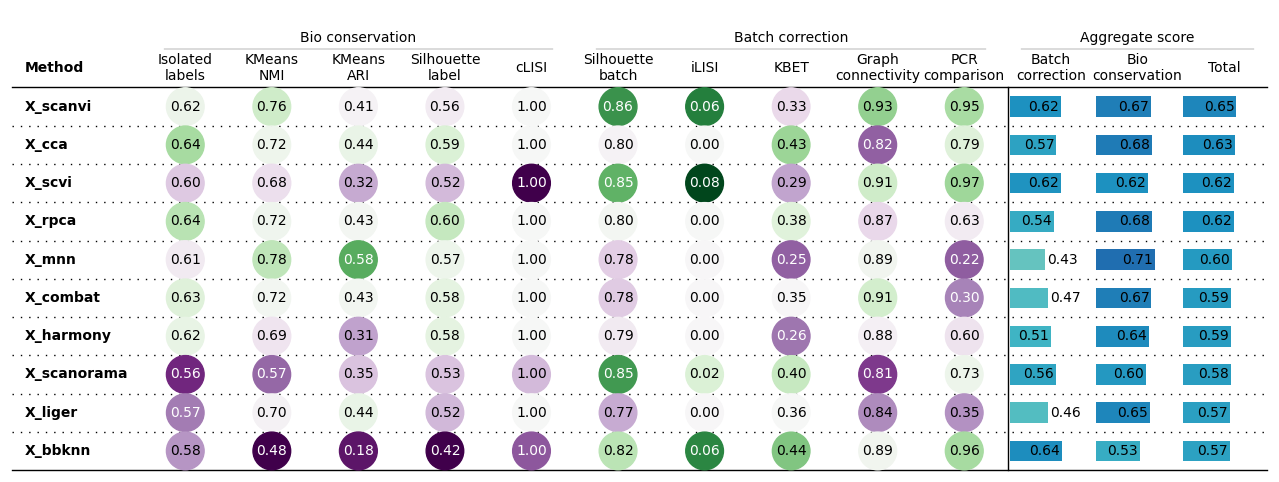


=== Fig 2: Batch Correction vs Bio Conservation 散点图 ===


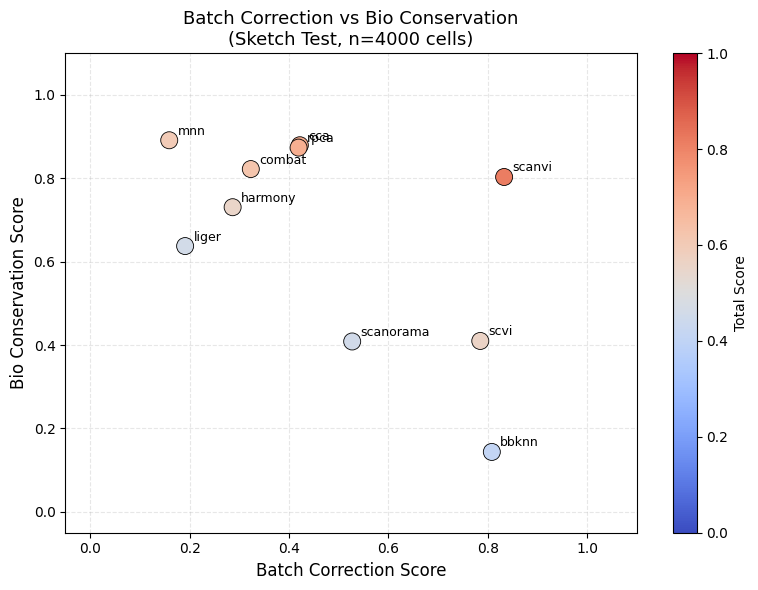


=== Fig 3: 综合得分条形图 ===


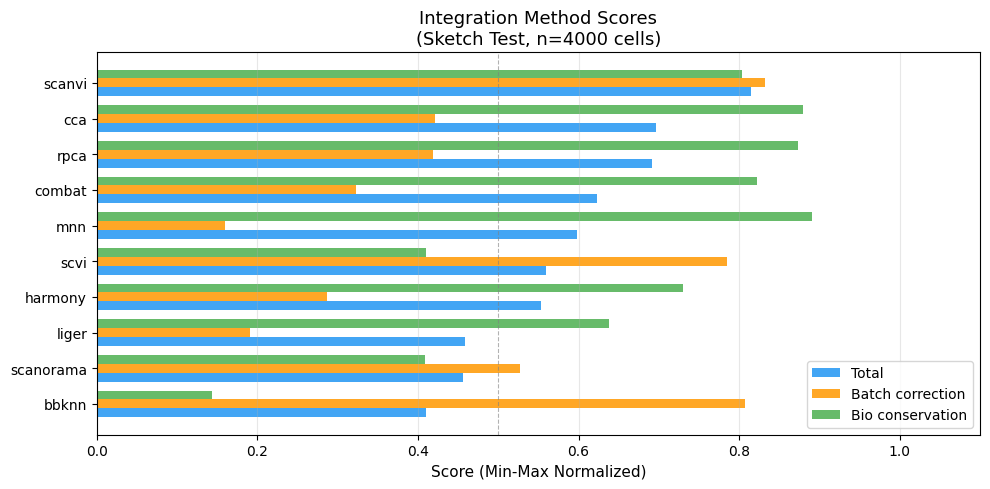


=== Fig 4: 单项指标雷达图 ===


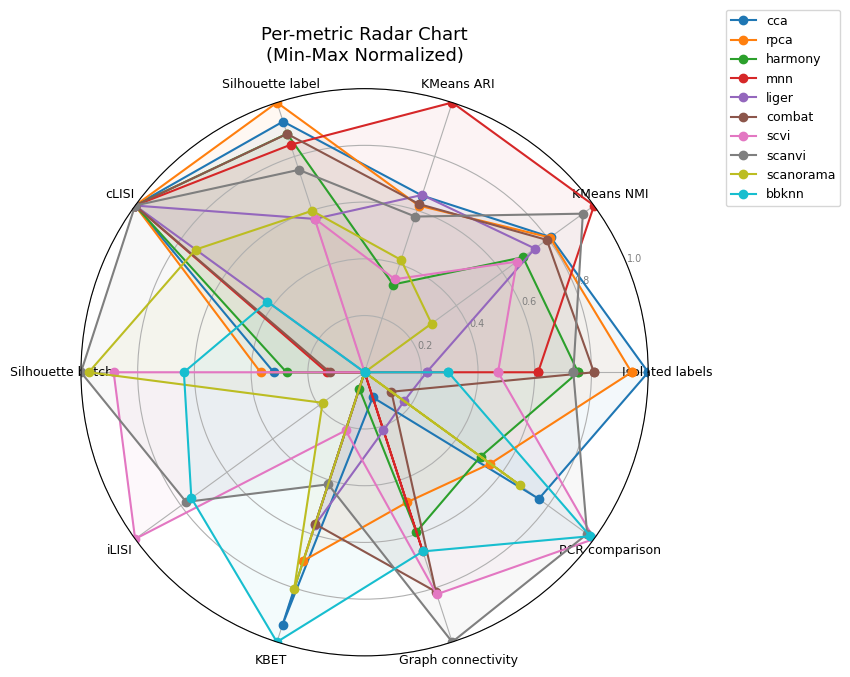


可视化完成！


In [5]:
#### ========== Part 8: Python - 可视化结果 ========== ####
## 【Python 内核 (scib-env)】

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

## ------------------------------------------------------------------ ##
## Fig 1: 完整指标热图（参考脚本 bm.plot_results_table）                ##
## ------------------------------------------------------------------ ##
print("=== Fig 1: Benchmark 完整指标热图 ===")
bm.plot_results_table(min_max_scale=False)
plt.show()

## ------------------------------------------------------------------ ##
## Fig 2: Batch correction vs Bio conservation 散点图                   ##
## ------------------------------------------------------------------ ##
print("\n=== Fig 2: Batch Correction vs Bio Conservation 散点图 ===")

results_plot = bm.get_results(min_max_scale=True)
bc_col  = "Batch correction"
bio_col = "Bio conservation"
tot_col = "Total"

plot_df = results_plot[[bc_col, bio_col, tot_col]].copy()
for col in [bc_col, bio_col, tot_col]:
    plot_df[col] = pd.to_numeric(plot_df[col], errors="coerce")
plot_df = plot_df.dropna()
plot_df.index = plot_df.index.str.replace("X_", "", regex=False)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    plot_df[bc_col],
    plot_df[bio_col],
    c=plot_df[tot_col],
    cmap="coolwarm",
    vmin=0, vmax=1,
    s=150,
    edgecolors="black",
    linewidths=0.6,
    zorder=3
)
plt.colorbar(scatter, ax=ax, label="Total Score")

for method, row in plot_df.iterrows():
    ax.annotate(
        method,
        (row[bc_col], row[bio_col]),
        textcoords="offset points",
        xytext=(6, 4),
        fontsize=9
    )

ax.set_xlabel("Batch Correction Score", fontsize=12)
ax.set_ylabel("Bio Conservation Score", fontsize=12)
ax.set_title("Batch Correction vs Bio Conservation\n(Sketch Test, n=4000 cells)", fontsize=13)
ax.grid(True, alpha=0.3, linestyle="--")
ax.set_xlim(-0.05, 1.1)
ax.set_ylim(-0.05, 1.1)
plt.tight_layout()
plt.show()

## ------------------------------------------------------------------ ##
## Fig 3: 综合得分条形图（Total / Batch / Bio 三列并排）                ##
## ------------------------------------------------------------------ ##
print("\n=== Fig 3: 综合得分条形图 ===")

bar_df = plot_df[[tot_col, bc_col, bio_col]].sort_values(tot_col, ascending=True)
bar_df.columns = ["Total", "Batch correction", "Bio conservation"]

x      = np.arange(len(bar_df))
width  = 0.25
colors = ["#2196F3", "#FF9800", "#4CAF50"]

fig, ax = plt.subplots(figsize=(10, 5))
for i, (col, color) in enumerate(zip(bar_df.columns, colors)):
    ax.barh(x + i * width, bar_df[col], width, label=col, color=color, alpha=0.85)

ax.set_yticks(x + width)
ax.set_yticklabels(bar_df.index, fontsize=10)
ax.set_xlabel("Score (Min-Max Normalized)", fontsize=11)
ax.set_title("Integration Method Scores\n(Sketch Test, n=4000 cells)", fontsize=13)
ax.set_xlim(0, 1.1)
ax.legend(loc="lower right", fontsize=10)
ax.axvline(0.5, color="gray", linestyle="--", linewidth=0.8, alpha=0.6)
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## ------------------------------------------------------------------ ##
## Fig 4: 各单项指标雷达图（每个方法一条线）                             ##
## ------------------------------------------------------------------ ##
print("\n=== Fig 4: 单项指标雷达图 ===")

results_raw = bm.get_results(min_max_scale=True)

## 筛选出各单项指标列（排除 Aggregate score 行和综合分数列）
metric_df = results_raw.copy()
metric_df.index = metric_df.index.str.replace("X_", "", regex=False)

## 仅保留 Metric Type 行为 "Metric" 的列（单项指标，非综合分数）
if "Metric Type" in metric_df.index:
    metric_types = metric_df.loc["Metric Type"]
    single_metric_cols = metric_types[
        ~metric_types.isin(["Aggregate score"])
    ].index.tolist()
    plot_metric_df = metric_df.drop(index="Metric Type")[single_metric_cols]
else:
    ## 回退：去掉明确的综合分数列
    drop_cols = [c for c in metric_df.columns if c in ["Batch correction", "Bio conservation", "Total"]]
    plot_metric_df = metric_df.drop(columns=drop_cols)

## 转数值
for col in plot_metric_df.columns:
    plot_metric_df[col] = pd.to_numeric(plot_metric_df[col], errors="coerce")
plot_metric_df = plot_metric_df.dropna(how="all")

labels   = list(plot_metric_df.columns)
n_labels = len(labels)
angles   = np.linspace(0, 2 * np.pi, n_labels, endpoint=False).tolist()
angles  += angles[:1]

cmap_fn   = plt.get_cmap("tab10")
n_methods = len(plot_metric_df)
fig, ax   = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

for idx, (method, row) in enumerate(plot_metric_df.iterrows()):
    values  = row.fillna(0).tolist()
    values += values[:1]
    color   = cmap_fn(idx % 10)
    ax.plot(angles, values, "o-", linewidth=1.5, label=method, color=color)
    ax.fill(angles, values, alpha=0.05, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=9)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], size=7, color="gray")
ax.set_title("Per-metric Radar Chart\n(Min-Max Normalized)", fontsize=13, pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.15), fontsize=9, framealpha=0.8)
plt.tight_layout()
plt.show()

print("\n可视化完成！")

In [ ]:
#### ========== Part 9: Python - 原始分数 & 归一化分数表格 ========== ####
## 【Python 内核 (scib-env)】

print("=== 原始分数 ===")
display(bm.get_results(min_max_scale=False))

print("\n=== 归一化分数（Min-Max Scaled）===")
display(bm.get_results(min_max_scale=True))

print("\n" + "="*60)
print("Benchmark 全部完成！")
print("="*60)